In [26]:
import pandas as pd
df = pd.read_csv("/Users/terlau/LNDG/EyeMem/EyeMem_1/DDM/EyeMem_hddm_study.csv")

In [27]:
print(df)
behav_1_sub9 = df[df["subj_idx"] == 9]
behav_1_sub9

       subj_idx  category  stim  response  accuracy     rt  age
0             9         3     1       2.0         1  0.971    0
1             9         3     1       1.0         0  1.367    0
2             9         3     0       1.0         1  0.989    0
3             9         3     1       2.0         1  0.692    0
4             9         3     0       1.0         1  0.806    0
...         ...       ...   ...       ...       ...    ...  ...
12366       101         3     1       1.0         1  0.645    1
12367       101         3     1       1.0         1  1.858    1
12368       101         3     0       2.0         1  0.759    1
12369       101         3     1       1.0         1  0.584    1
12370       101         3     0       2.0         1  0.770    1

[12371 rows x 7 columns]


,subj_idx,category,stim,response,accuracy,rt,age
0,9,3,1,2.0,1,0.971,0
1,9,3,1,1.0,0,1.367,0
2,9,3,0,1.0,1,0.989,0
3,9,3,1,2.0,1,0.692,0
4,9,3,0,1.0,1,0.806,0
...,...,...,...,...,...,...,...
144,9,4,0,1.0,1,0.915,0
145,9,4,0,1.0,1,0.717,0
146,9,4,1,2.0,1,0.649,0
147,9,4,1,2.0,1,0.667,0


In [14]:
# Remove short and long RTs, as in 10.1523/JNEUROSCI.4684-04.2005.
# This is not strictly necessary, but is performed here for
# compatibility with this study.
df_rt = behav_1_sub9[behav_1_sub9["rt"] > .1] # Remove trials less than 100ms
df_rt = df_rt[df_rt["rt"] < 1.65] # Remove trials greater than 1650ms
df_rt

,subj_idx,category,stim,response,accuracy,rt,age
0,9,3,1,2.0,1,0.971,0
1,9,3,1,1.0,0,1.367,0
2,9,3,0,1.0,1,0.989,0
3,9,3,1,2.0,1,0.692,0
4,9,3,0,1.0,1,0.806,0
...,...,...,...,...,...,...,...
144,9,4,0,1.0,1,0.915,0
145,9,4,0,1.0,1,0.717,0
146,9,4,1,2.0,1,0.649,0
147,9,4,1,2.0,1,0.667,0


In [17]:
from ddm import Sample
# Create a sample object from our data.  This is the standard input
# format for fitting procedures.  Since RT and correct/error are
# both mandatory columns, their names are specified by command line
# arguments.
test_sample = Sample.from_pandas_dataframe(df_rt, rt_column_name="rt", correct_column_name="accuracy")

In [18]:
import ddm.models
#drift rate vary with the stim (ie if target present or not) as drift represents evidence and this differes dependent on stim
#how do we include age or category?
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    required_parameters = ["driftcoh"] # <-- Parameters we want to include in the model
    required_conditions = ["stim"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.
    
    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, conditions, **kwargs):
        return self.driftcoh * conditions['stim']


In [20]:
from ddm import Model, Fittable
from ddm.functions import fit_adjust_model, display_model
from ddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
model_rs = Model(name='test data, drift varies with stim',
                 drift=DriftCoherence(driftcoh=Fittable(minval=0, maxval=20)),
                 noise=NoiseConstant(noise=1),
                 bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
                 # Since we can only have one overlay, we use
                 # OverlayChain to string together multiple overlays.
                 # They are applied sequentially in order.  OverlayNonDecision
                 # implements a non-decision time by shifting the
                 # resulting distribution of response times by
                 # `nondectime` seconds.
                 overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                                OverlayPoissonMixture(pmixturecoef=.02,
                                                                      rate=1)]),
                 dx=.001, dt=.01, T_dur=2)

# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_model_rs = fit_adjust_model(sample=test_sample, model=model_rs, verbose=False)


Params [1.93941697 0.76928782 0.3919448 ] gave 32.26820396817868


In [21]:
display_model(fit_model_rs)

Model test data, drift varies with stim information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoh: 1.939417
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.769288
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.391945
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 32.26820396817868
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 3


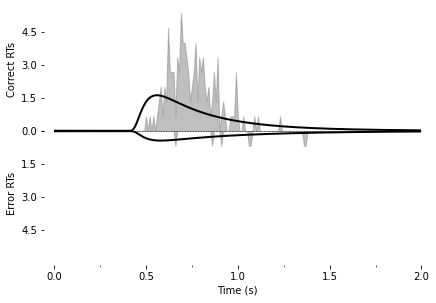

In [22]:
import ddm.plot
import matplotlib.pyplot as plt
ddm.plot.plot_fit_diagnostics(model=fit_model_rs, sample=test_sample)
#plt.savefig("roitman-fit.png")
plt.show()


In [29]:
df

,subj_idx,category,stim,response,accuracy,rt,age
0,9,3,1,2.0,1,0.971,0
1,9,3,1,1.0,0,1.367,0
2,9,3,0,1.0,1,0.989,0
3,9,3,1,2.0,1,0.692,0
4,9,3,0,1.0,1,0.806,0
...,...,...,...,...,...,...,...
12366,101,3,1,1.0,1,0.645,1
12367,101,3,1,1.0,1,1.858,1
12368,101,3,0,2.0,1,0.759,1
12369,101,3,1,1.0,1,0.584,1


In [30]:
# compute T_dur:
T_dur = df['rt'].max()+1
T_dur 

3.497

In [34]:
pwd

'/Users/terlau/LNDG/EyeMem'

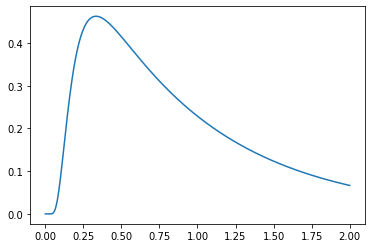

In [5]:
import matplotlib.pyplot as plt
from ddm import Model
m = Model()
s = m.solve()
plt.plot(s.model.t_domain(), s.pdf_corr())
#plt.savefig("helloworld.png")
plt.show()


In [6]:
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision
from ddm.functions import fit_adjust_model, display_model

model = Model(name='Simple model',
              drift=DriftConstant(drift=2.2),
              noise=NoiseConstant(noise=1.5),
              bound=BoundConstant(B=1.1),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2)
display_model(model)
sol = model.solve()

Model Simple model information:
Drift component DriftConstant:
    constant
    Fixed parameters:
    - drift: 2.200000
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.500000
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.100000
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fixed parameters:
    - nondectime: 0.100000



In [7]:
#generate psuedo-data from this solved model with the resample() function
samp = sol.resample(1000)

In [9]:
from ddm import Fittable
from ddm.models import LossRobustBIC
from ddm.functions import fit_adjust_model
model_fit = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=1.1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=2)

fit_adjust_model(samp, model_fit,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)

Params [2.20536714 1.45855076 0.10962332] gave 486.85170512403204


Model(name='Simple model (fitted)', drift=DriftConstant(drift=Fitted(2.2053671404674007, minval=0, maxval=4)), noise=NoiseConstant(noise=Fitted(1.4585507576422734, minval=0.5, maxval=4)), bound=BoundConstant(B=1.1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.10962331623309463, minval=0, maxval=1)), dx=0.001, dt=0.01, T_dur=2, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=486.85170512403204, nparams=3, samplesize=1000, mess=''))

In [10]:
display_model(model_fit)

Model Simple model (fitted) information:
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 2.205367
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 1.458551
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.100000
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.109623
Fit information:
    Loss function: BIC
    Loss function value: 486.85170512403204
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 3
        - samplesize: 1000
        - mess: ''



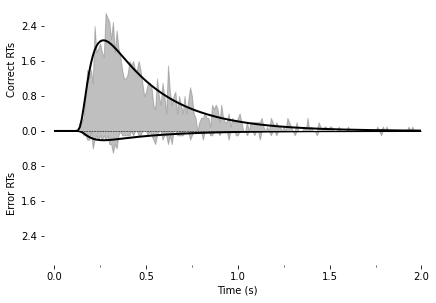

In [11]:
import ddm.plot
ddm.plot.plot_fit_diagnostics(model=model_fit, sample=samp)
#plt.savefig("simple-fit.png")
plt.show()



In [12]:
print(sol.prob_correct())
print(sol.pdf_err())

0.8937015385162344
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.07365499e-10
 5.00458955e-05 2.38145936e-03 1.43848498e-02 3.90619605e-02
 7.20389916e-02 1.07279501e-01 1.40406765e-01 1.69113545e-01
 1.92585355e-01 2.10874478e-01 2.24459235e-01 2.33980790e-01
 2.40101611e-01 2.43437087e-01 2.44527962e-01 2.43834117e-01
 2.41738697e-01 2.38556580e-01 2.34544091e-01 2.29908443e-01
 2.24816229e-01 2.19400774e-01 2.13768322e-01 2.08003174e-01
 2.02171914e-01 1.96326847e-01 1.90508801e-01 1.84749393e-01
 1.79072854e-01 1.73497511e-01 1.68036971e-01 1.62701084e-01
 1.57496705e-01 1.52428321e-01 1.47498541e-01 1.42708501e-01
 1.38058181e-01 1.33546658e-01 1.29172320e-01 1.24933024e-01
 1.20826228e-01 1.16849097e-01 1.12998587e-01 1.09271511e-01
 1.05664589e-01 1.02174491e-01 9.87978738e-02 9.55313982e-02
 9.23717551e-02 8.93156782e-02 8.63599563e-02 8.35014413e-02
 8.07